In [1]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans,KMeans,DBSCAN
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import rand_score, normalized_mutual_info_score
from collections import Counter, defaultdict
import ipdb
from PIL import Image
from collections import Counter, defaultdict
import seaborn as sns


In [2]:
def show_farthest_images(json_path, image_base_path, class_id=None, images_per_row=10, num_images=50):
    """
    Display the farthest images for a given class or allow class selection.
    
    Args:
        json_path: Path to the JSON file containing farthest images information
        image_base_path: Base path to the tiny-imagenet images
        class_id: Specific class to display (if None, will prompt for selection)
        images_per_row: Number of images to display per row
        num_images: Number of images to display (max 50)
    """
    # Load JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # If no class specified, show available classes and prompt for selection
    if class_id is None:
        print("Available classes:")
        for idx, cls in enumerate(sorted(data.keys())):
            print(f"{idx + 1}: {cls}")
        selected_idx = input("Enter the number of the class you want to view: ")
        class_id = sorted(data.keys())[int(selected_idx) - 1]
    
    images = data[class_id][:num_images]
    num_rows = int(np.ceil(len(images) / images_per_row))
    
    # Create figure
    plt.figure(figsize=(20, 2 * num_rows))
    plt.suptitle(f"Farthest {num_images} Images from Centroid - Class {class_id}", fontsize=16)
    
    # Plot images
    for idx, img_name in enumerate(images):
        img_path = os.path.join(image_base_path, class_id, 'images', img_name)
        
        try:
            img = Image.open(img_path)
            plt.subplot(num_rows, images_per_row, idx + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Rank {idx + 1}", fontsize=8)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()


In [3]:

def explore_class_distribution(json_path):
    """
    Show distribution of images across classes
    
    Args:
        json_path: Path to the JSON file containing farthest images information
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    class_counts = {cls: len(images) for cls, images in data.items()}
    
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(class_counts)), list(class_counts.values()))
    plt.xlabel('Class Index')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Farthest Images Across Classes')
    plt.show()
    
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Average images per class: {np.mean(list(class_counts.values())):.2f}")
    print(f"Min images per class: {min(class_counts.values())}")
    print(f"Max images per class: {max(class_counts.values())}")



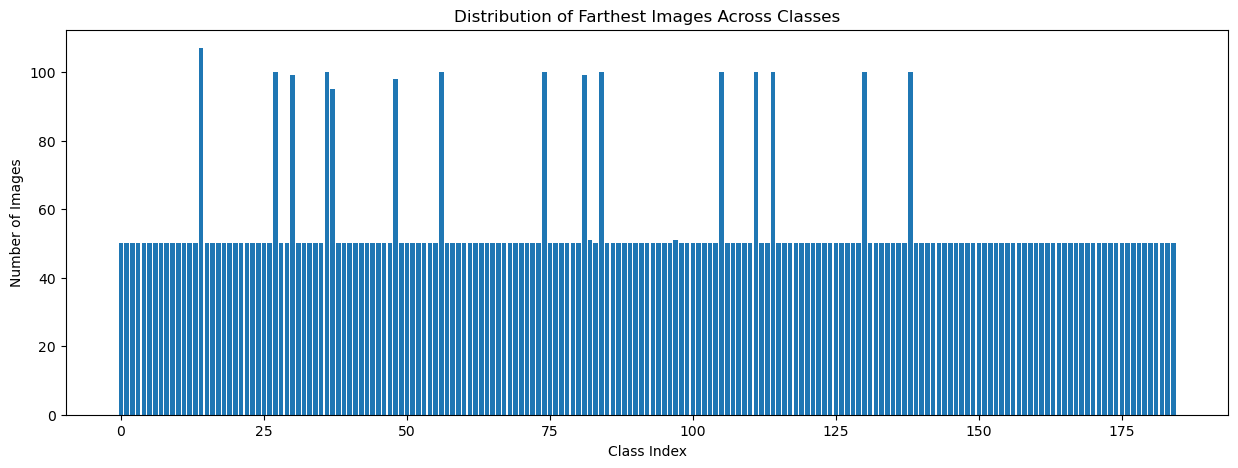

Total number of classes: 185
Average images per class: 54.05
Min images per class: 50
Max images per class: 107


In [4]:
# 1. Show distribution of images across classes
explore_class_distribution('ds_inf/key50_far_latents_train_vit_image_feature_CLS.json')

Available classes:
1: n01443537
2: n01629819
3: n01644900
4: n01698640
5: n01742172
6: n01768244
7: n01770393
8: n01774384
9: n01774750
10: n01784675
11: n01855672
12: n01882714
13: n01910747
14: n01917289
15: n01944390
16: n01945685
17: n01950731
18: n01983481
19: n01984695
20: n02002724
21: n02056570
22: n02058221
23: n02074367
24: n02085620
25: n02094433
26: n02099601
27: n02106662
28: n02113799
29: n02124075
30: n02125311
31: n02129165
32: n02132136
33: n02165456
34: n02190166
35: n02206856
36: n02226429
37: n02231487
38: n02233338
39: n02236044
40: n02268443
41: n02279972
42: n02281406
43: n02321529
44: n02364673
45: n02395406
46: n02403003
47: n02410509
48: n02415577
49: n02423022
50: n02437312
51: n02481823
52: n02486410
53: n02504458
54: n02509815
55: n02666196
56: n02669723
57: n02699494
58: n02730930
59: n02788148
60: n02791270
61: n02793495
62: n02795169
63: n02802426
64: n02808440
65: n02814533
66: n02814860
67: n02815834
68: n02823428
69: n02837789
70: n02841315
71: n02843

Enter the number of the class you want to view:  50


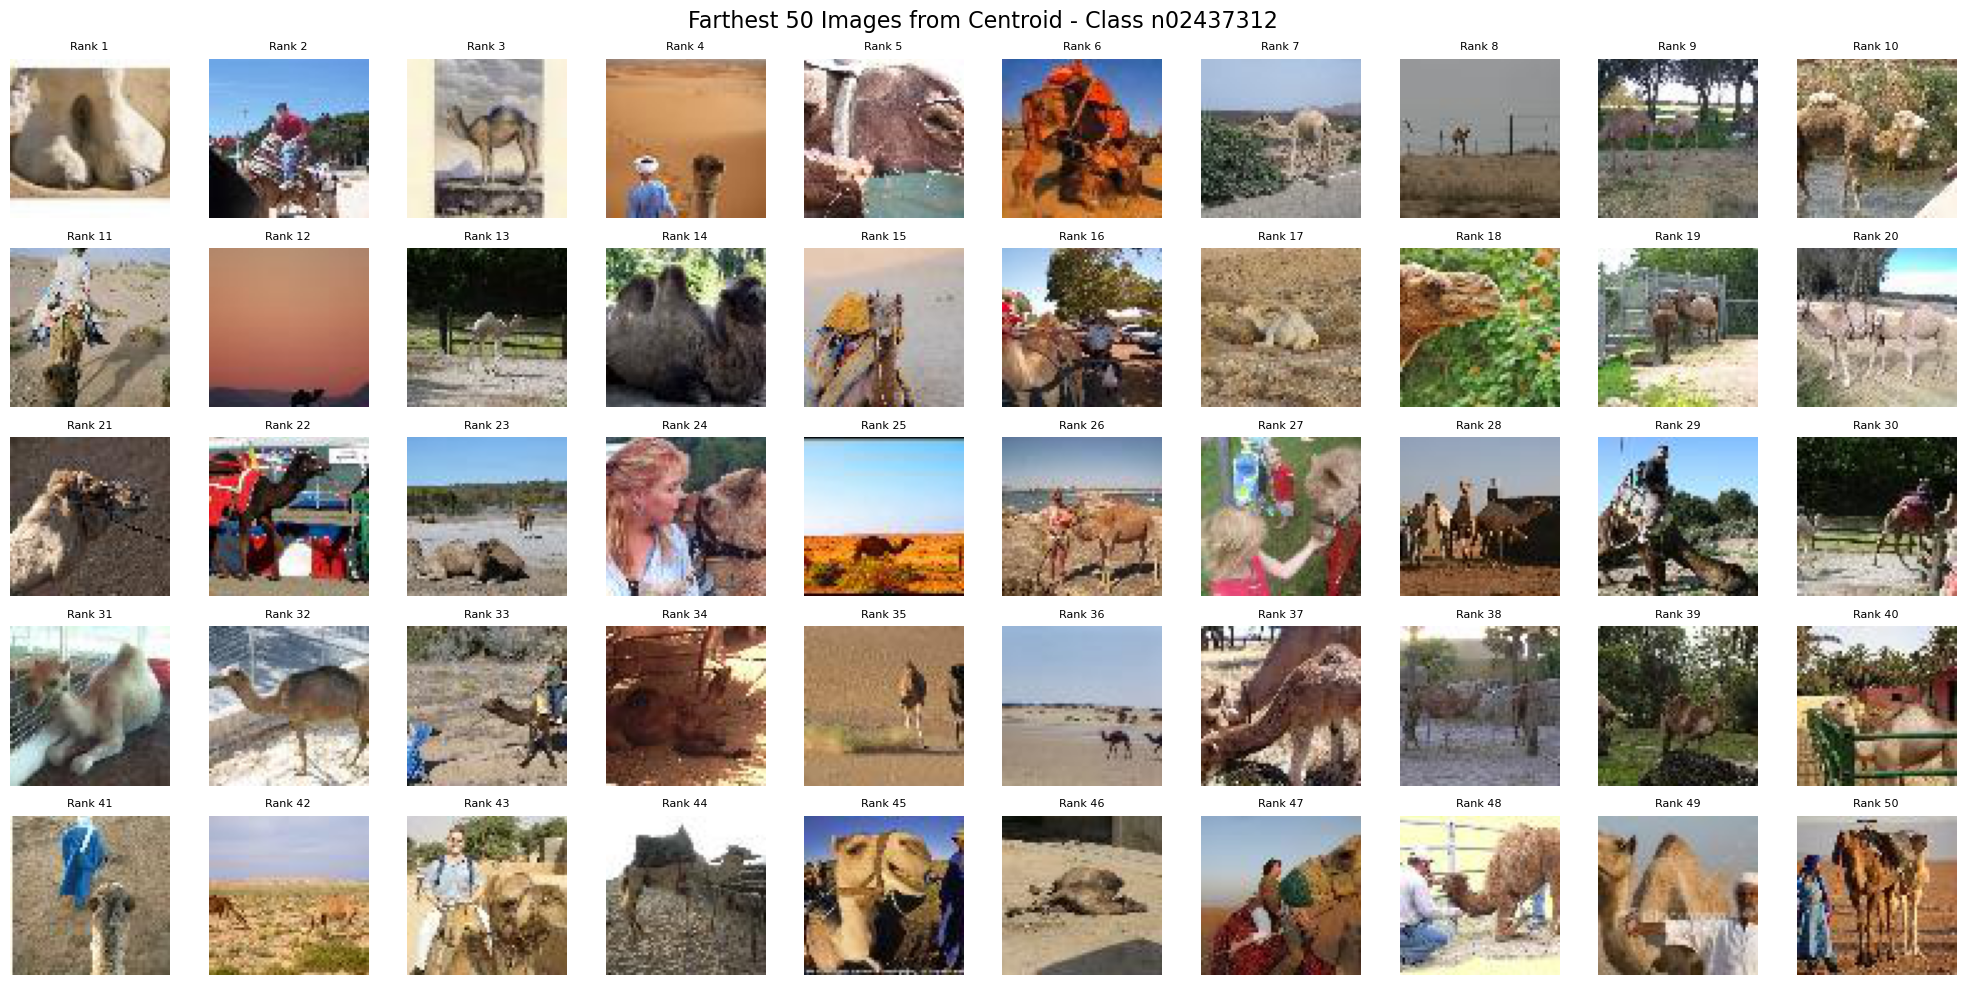

In [7]:
# 2. View images for a specific class
show_farthest_images(
    json_path='ds_inf/key50_far_latents_train_vit_image_feature_CLS.json',
    image_base_path='/scratch/zhao.lin1/dataset/tiny-imagenet-200/train',
    class_id=None  # Will prompt for class selection
)

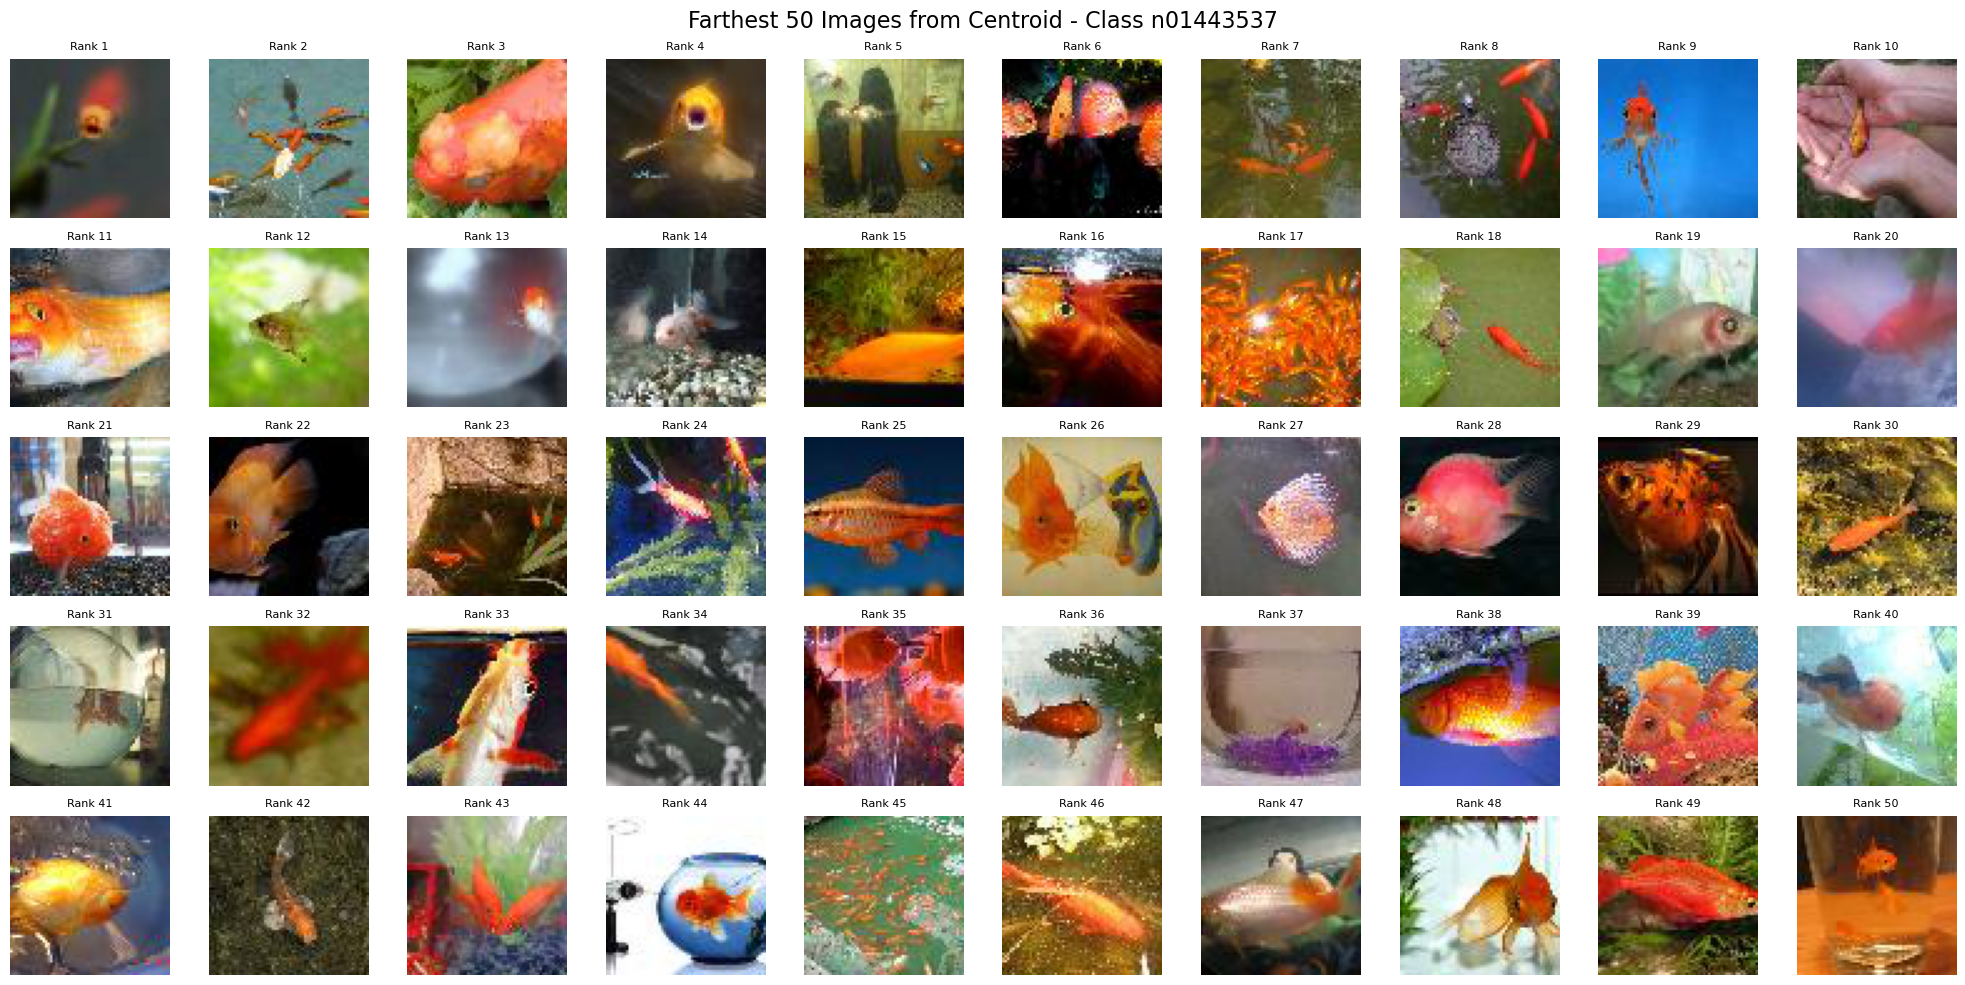

In [9]:
# 3. View images for a specific class directly
show_farthest_images(
    json_path='ds_inf/key50_far_latents_train_vit_image_feature_CLS.json',
    image_base_path='/scratch/zhao.lin1/dataset/tiny-imagenet-200/train',
    class_id='n01443537'
)

In [2]:
def load_and_process_data(input_dir, wnid_mapping_path):
    """Load and process the ViT features"""
    wnid_to_index = {}
    with open(wnid_mapping_path, 'r') as f:
        for line in f:
            wnid, index = line.strip().split()
            wnid_to_index[wnid] = int(index)
            
    latents = []
    labels = []
    file_paths = []
    
    for class_folder in sorted(os.listdir(input_dir)):
        class_dir = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_dir):
            for file_name in sorted(os.listdir(class_dir)):
                if file_name.endswith('.pt'):
                    file_path = os.path.join(class_dir, file_name)
                    file_paths.append(file_path)
                    latent = torch.load(file_path, weights_only=True)
                    latents.append(latent.cpu().numpy())
                    labels.append(wnid_to_index[file_name.split('_')[0]])
    
    return np.stack(latents).astype(np.float32), np.array(labels), file_paths

In [3]:
def visualize_clustering(latents, labels, file_paths, n_clusters=200, save_dir=None):
    """Visualize K-means++ clustering results"""
    # Perform K-means++ clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
    kmeans.fit(latents)
    y_kmeans = kmeans.predict(latents)
    
    # Get distances to cluster centers
    distances = kmeans.transform(latents)
    
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)
    
    # Create mapping for true labels
    mapping_candidates = defaultdict(list)
    for sample, true in zip(y_kmeans, labels):
        mapping_candidates[sample].append(true)
    label_mapping = {sample: Counter(trues).most_common(1)[0][0]
                    for sample, trues in mapping_candidates.items()}
    
    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Scatter plot of samples
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=y_kmeans, cmap='viridis', alpha=0.6)
    plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0],
               pca.transform(kmeans.cluster_centers_)[:, 1],
               c='red', marker='x', s=200, linewidth=3, label='Centroids')
    plt.title('K-means++ Clustering Visualization (PCA)')
    plt.legend()
    
    # Plot 2: Distance distribution
    plt.subplot(1, 2, 2)
    min_distances = np.min(distances, axis=1)
    sns.histplot(data=min_distances, bins=50)
    plt.title('Distribution of Distances to Nearest Centroid')
    plt.xlabel('Distance')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return y_kmeans, distances, label_mapping

In [4]:
def show_farthest_images_per_cluster(image_base_path, file_paths, distances, y_kmeans, cluster_id, n_images=10):
    """Show the farthest images from a specific cluster centroid"""
    cluster_mask = y_kmeans == cluster_id
    cluster_distances = distances[cluster_mask, cluster_id]
    cluster_files = np.array(file_paths)[cluster_mask]
    
    # Sort by distance (descending)
    sorted_indices = np.argsort(cluster_distances)[::-1]
    farthest_files = cluster_files[sorted_indices[:n_images]]
    farthest_distances = cluster_distances[sorted_indices[:n_images]]
    
    # Display images
    plt.figure(figsize=(20, 4))
    for idx, (file_path, distance) in enumerate(zip(farthest_files, farthest_distances)):
        class_folder = file_path.split('/')[-2]
        image_name = file_path.split('/')[-1].replace('.pt', '.JPEG')
        img_path = os.path.join(image_base_path, class_folder, 'images', image_name)
        
        plt.subplot(1, n_images, idx + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Distance: {distance:.2f}')
    
    plt.suptitle(f'Farthest {n_images} Images from Cluster {cluster_id} Centroid')
    plt.tight_layout()
    plt.show()

In [5]:
# Example usage
def main():
    # Update these paths
    input_dir = '/scratch/zhao.lin1/dataset/tiny-imagenet-200/train_vit_image_feature_CLS'
    image_base_path = 'scratch/zhao.lin1/dataset/tiny-imagenet-200/train'
    wnid_mapping_path = 'ds_inf/tiny-imagenet-200/tiny-imagenet-mapping.txt'
    
    # Load and process data
    print("Loading data...")
    latents, labels, file_paths = load_and_process_data(input_dir, wnid_mapping_path)
    
    # Perform clustering and visualization
    print("Performing clustering...")
    y_kmeans, distances, label_mapping = visualize_clustering(latents, labels, file_paths)
    
    # Show farthest images for a specific cluster
    cluster_id = 0  # Change this to view different clusters
    show_farthest_images_per_cluster(image_base_path, file_paths, distances, y_kmeans, cluster_id)
    
    # Print some clustering statistics
    print("\nClustering Statistics:")
    print(f"Number of clusters: {len(np.unique(y_kmeans))}")
    cluster_sizes = Counter(y_kmeans)
    print(f"Average cluster size: {np.mean(list(cluster_sizes.values())):.2f}")
    print(f"Largest cluster size: {max(cluster_sizes.values())}")
    print(f"Smallest cluster size: {min(cluster_sizes.values())}")


Loading data...
Performing clustering...


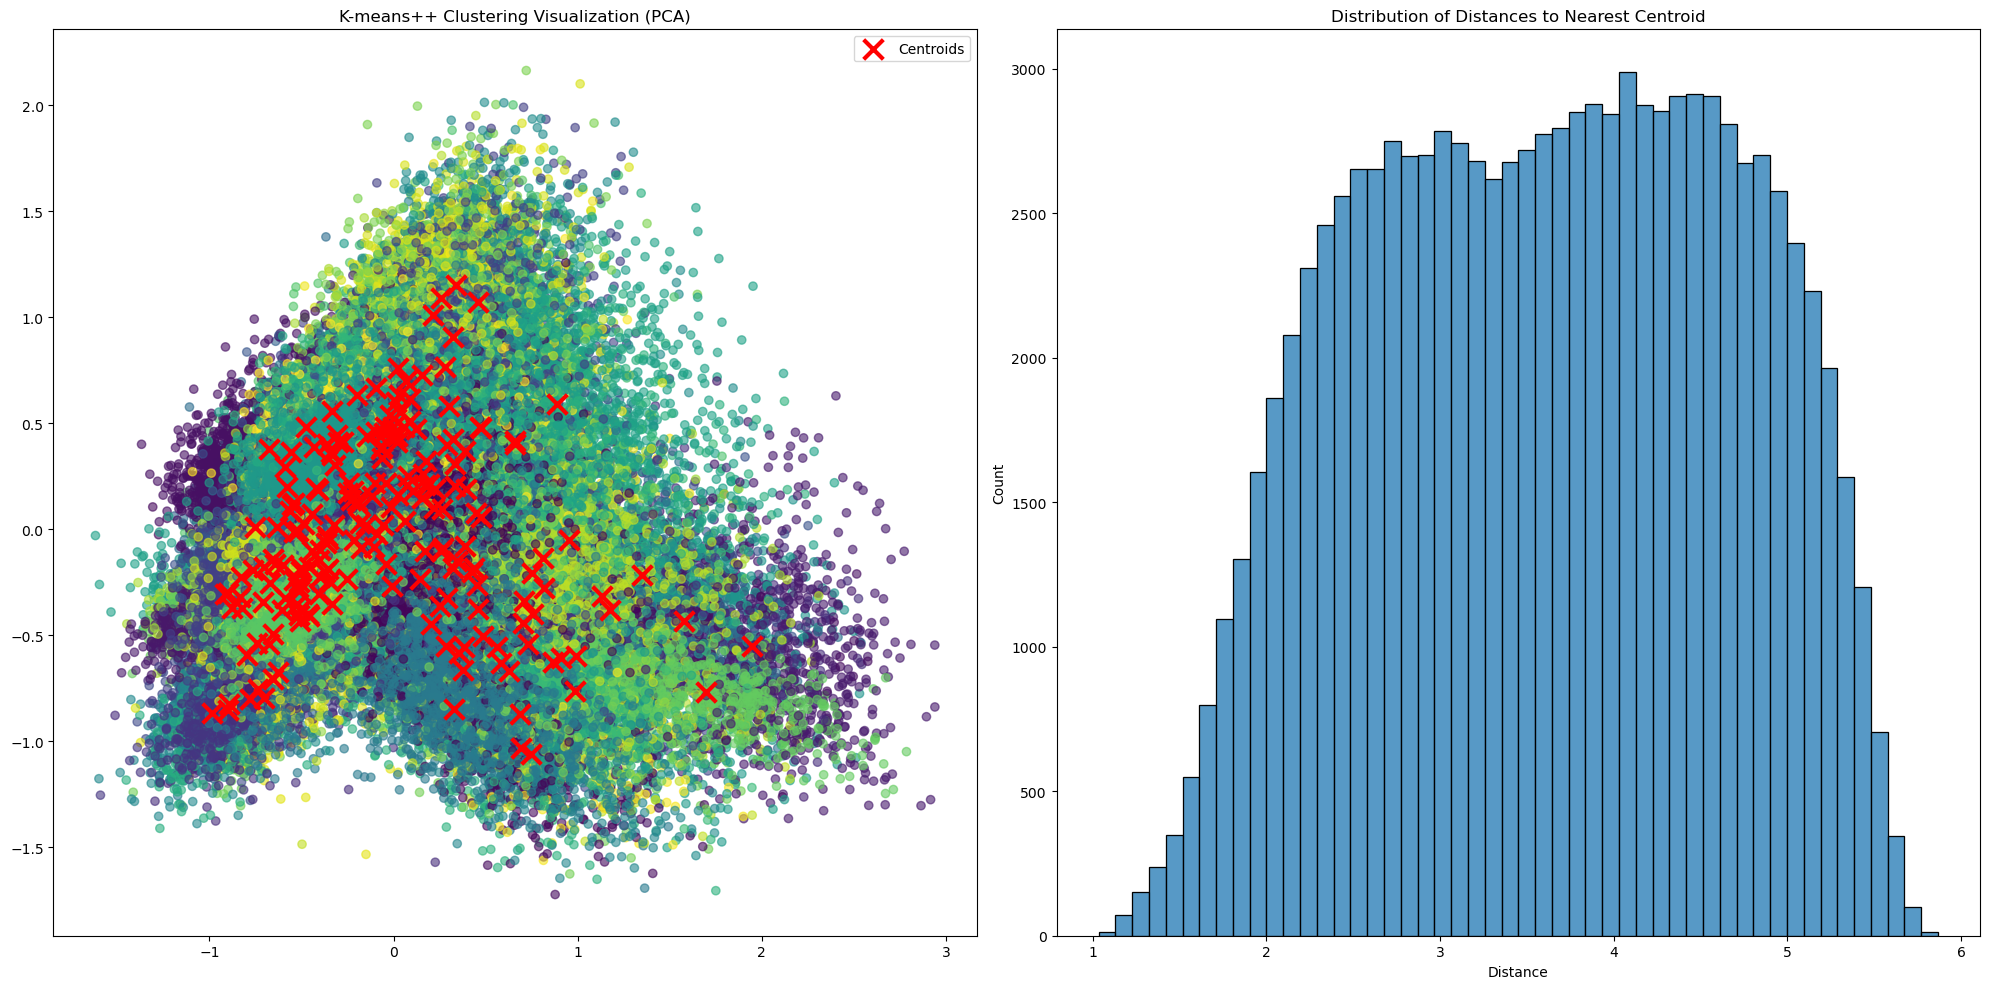

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhao.lin1/DD-DDIM-Inversion/scratch/zhao.lin1/dataset/tiny-imagenet-200/train/n03544143/images/n03544143_396.JPEG'

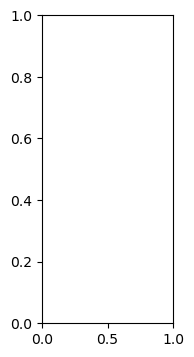

In [6]:
main()